In [2]:
! pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 7.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 16.9 MB/s eta 0:00:00


In [4]:
! pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 15.9 MB/s eta 0:00:00a 0:00:01


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   52
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -661.552
Date:                Fri, 10 May 2024   AIC                           1329.104
Time:                        02:22:04   BIC                           1334.958
Sample:                    01-01-2023   HQIC                          1331.349
                         - 12-24-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5.025e+05   7.94e+04      6.327      0.000    3.47e+05    6.58e+05
ar.L1          0.2691      0.113      2.380      0.017       0.047       0.491
sigma2      6.562e+09      2.081   3.15e+09      0.0

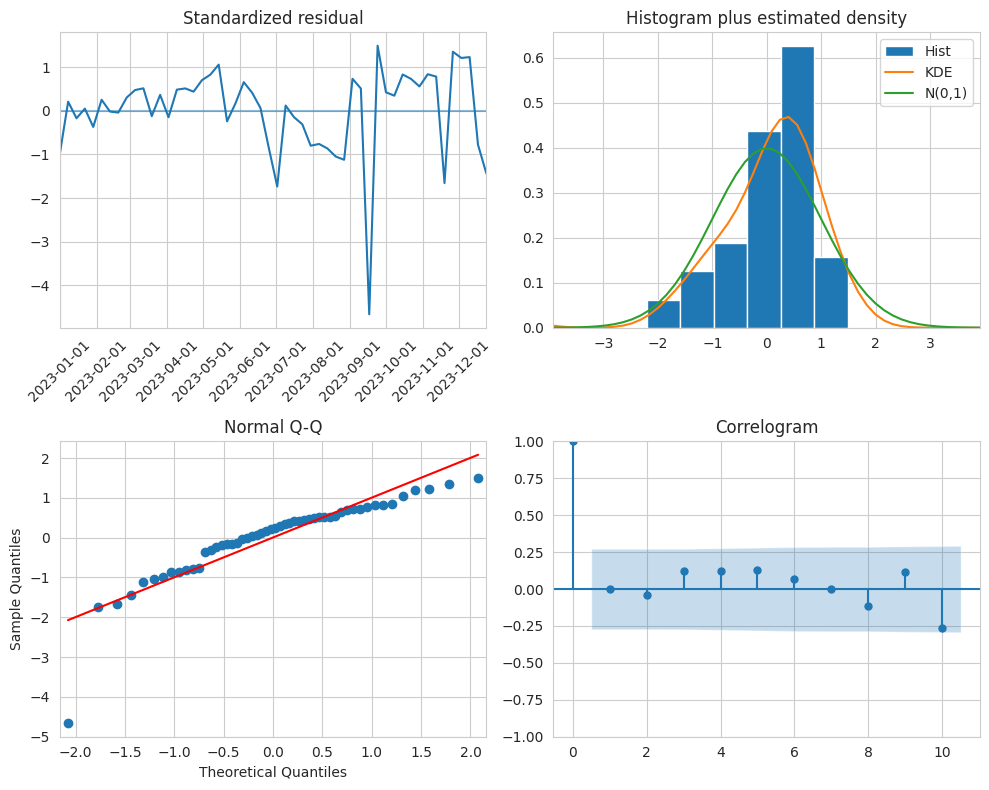

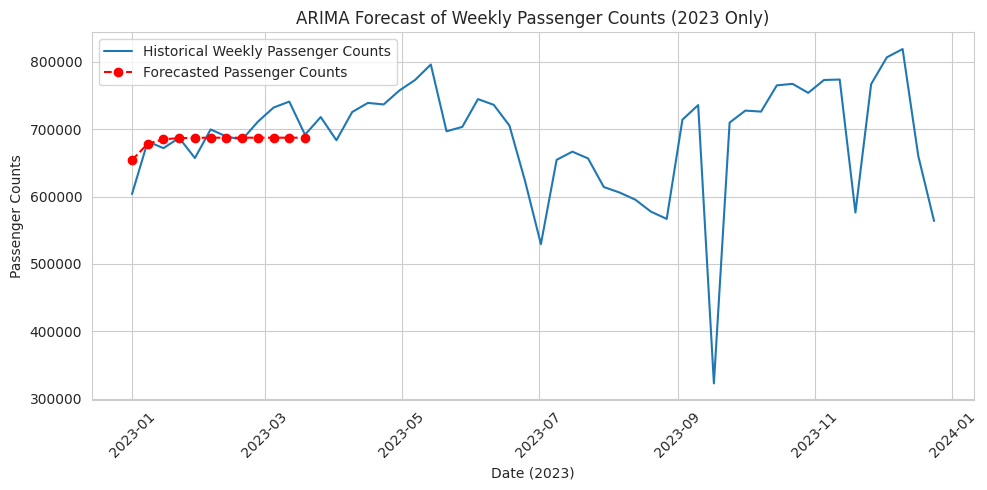

ADF Statistic: -5.227068
p-value: 0.000008


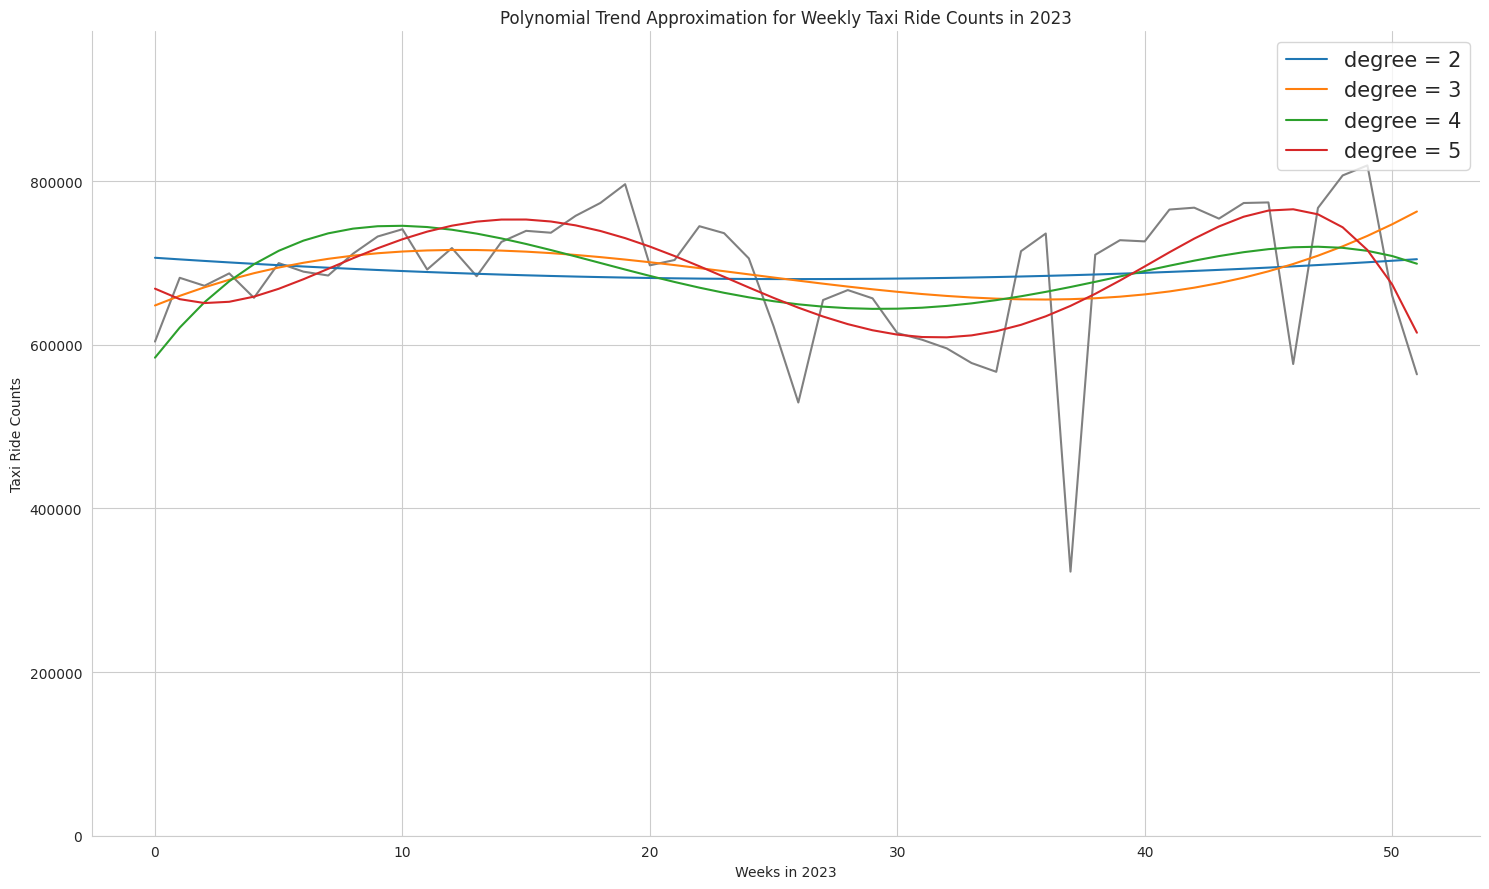

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from matplotlib.dates import DateFormatter
import pmdarima as pm
import seaborn as sns

class TimeSeriesAnalysis:
    def __init__(self, file_path):
        """Initialize the processor with a parquet file path."""
        self.file_path = file_path
        self.data = None
        self.weekly_passenger_counts = None

    def load_data(self):
        """Load and preprocess the data."""
        try:
            # Read parquet data
            self.data = pd.read_parquet(self.file_path)
            
            # Ensure all column names are lowercase
            self.data.columns = map(str.lower, self.data.columns)
            
            # Convert datetime columns to proper format
            self.data['tpep_pickup_datetime'] = pd.to_datetime(self.data['tpep_pickup_datetime'], errors='coerce')
            self.data['tpep_dropoff_datetime'] = pd.to_datetime(self.data['tpep_dropoff_datetime'], errors='coerce')
            
            # Drop rows with missing datetime values
            self.data.dropna(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime'], inplace=True)
            
            # Extract relevant time features
            self.data['year'] = self.data['tpep_pickup_datetime'].dt.year
            self.data['week'] = self.data['tpep_pickup_datetime'].dt.isocalendar().week
            
            # Filter for the year 2023
            self.data = self.data[self.data['year'] == 2023]
            
            # Group data by year and week to count passenger rides
            self.weekly_passenger_counts = self.data.groupby(['year', 'week']).size()

        except Exception as e:
            print(f"An error occurred during data loading: {e}")

    def adf_test(self):
        """Perform the Augmented Dickey-Fuller (ADF) test to check for stationarity."""
        if self.weekly_passenger_counts is not None:
            result = adfuller(self.weekly_passenger_counts.dropna())
            print('ADF Statistic: %f' % result[0])
            print('p-value: %f' % result[1])
        else:
            print("Weekly passenger counts are not available. Load the data first.")

    def visualize_counts(self):
        """Visualize weekly taxi ride counts."""
        if self.weekly_passenger_counts is not None:
            sns.set_style("whitegrid")
            x = np.arange(len(self.weekly_passenger_counts))
            degrees = [2, 3, 4, 5]

            fig, ax = plt.subplots(figsize=(15, 9))
            ax.plot(self.weekly_passenger_counts.values, color='gray')
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)

            for d in degrees:
                coef_t = np.polyfit(x, self.weekly_passenger_counts.values, deg=d)
                poly_t = np.poly1d(coef_t)
                trend = pd.Series(data=poly_t(x), index=self.weekly_passenger_counts.index)
                ax.plot(trend.values, label=f'degree = {d}')

            plt.legend(loc='upper right', fontsize=15)
            plt.ylim(0, max(self.weekly_passenger_counts) * 1.2)
            plt.title('Polynomial Trend Approximation for Weekly Taxi Ride Counts in 2023')
            plt.xlabel('Weeks in 2023')
            plt.ylabel('Taxi Ride Counts')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else:
            print("Weekly passenger counts are not available. Load the data first.")


class ARIMAForecaster:
    def __init__(self, data_series):
        """Initialize the ARIMA forecaster with a series to analyze."""
        self.data_series = data_series
        self.model = None
        self.forecasts = None

    def preprocess_data(self):
        """Preprocess the data for ARIMA modeling."""
        # Make sure the data series is indexed by date
        if not isinstance(self.data_series.index, pd.DatetimeIndex):
            self.data_series.index = pd.date_range(start='2023-01-01', periods=len(self.data_series), freq='W')

    def auto_fit(self, seasonal=False, m=1):
        """Automatically fit an ARIMA model with modified seasonal settings."""
        self.preprocess_data()
        try:
            self.model = pm.auto_arima(self.data_series, seasonal=seasonal, m=m, suppress_warnings=True)
            print(self.model.summary())
        except ValueError as e:
            print(f"An error occurred while fitting the model: {e}")
            print("Adjust the seasonal settings or increase the sample size.")

    def plot_diagnostics(self):
        """Plot the diagnostic figures for the ARIMA model."""
        if self.model is None:
            raise ValueError("Model is not fitted yet.")
        fig = self.model.plot_diagnostics(figsize=(10, 8))

        axes = fig.get_axes()
        standard_resid_ax = axes[0]
        standard_resid_ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
        standard_resid_ax.tick_params(axis='x', rotation=45)
        fig.tight_layout()
        plt.show()

    def forecast(self, periods=12):
        """Generate future forecasts and visualize them."""
        if self.model is None:
            raise ValueError("Model is not fitted yet.")
        self.forecasts, _ = self.model.predict(n_periods=periods, return_conf_int=True)

        forecast_dates_2023 = pd.date_range(start='2023-01-01', periods=periods, freq='W')
        historical_2023 = self.data_series[self.data_series.index >= '2023-01-01']

        plt.figure(figsize=(10, 5))
        plt.plot(historical_2023.index, historical_2023, label='Historical Weekly Passenger Counts')
        plt.plot(forecast_dates_2023, self.forecasts, label='Forecasted Passenger Counts', linestyle='--', marker='o', color='red')
        plt.title('ARIMA Forecast of Weekly Passenger Counts (2023 Only)')
        plt.xlabel('Date (2023)')
        plt.ylabel('Passenger Counts')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Calling the Functions
# Initialize the TimeSeriesAnalysis and load data
tsa = TimeSeriesAnalysis(file_path="/app/full_df.parquet")
tsa.load_data()

# Initialize the forecaster and fit an ARIMA model
forecaster = ARIMAForecaster(tsa.weekly_passenger_counts)
forecaster.auto_fit()
forecaster.plot_diagnostics()
forecaster.forecast()

# After fitting the ARIMA model, you can perform the ADF test and visualize counts
tsa.adf_test()
tsa.visualize_counts()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   52
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -661.552
Date:                Fri, 10 May 2024   AIC                           1329.104
Time:                        02:32:45   BIC                           1334.958
Sample:                    01-01-2023   HQIC                          1331.349
                         - 12-24-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5.025e+05   7.94e+04      6.327      0.000    3.47e+05    6.58e+05
ar.L1          0.2691      0.113      2.380      0.017       0.047       0.491
sigma2      6.562e+09      2.081   3.15e+09      0.0

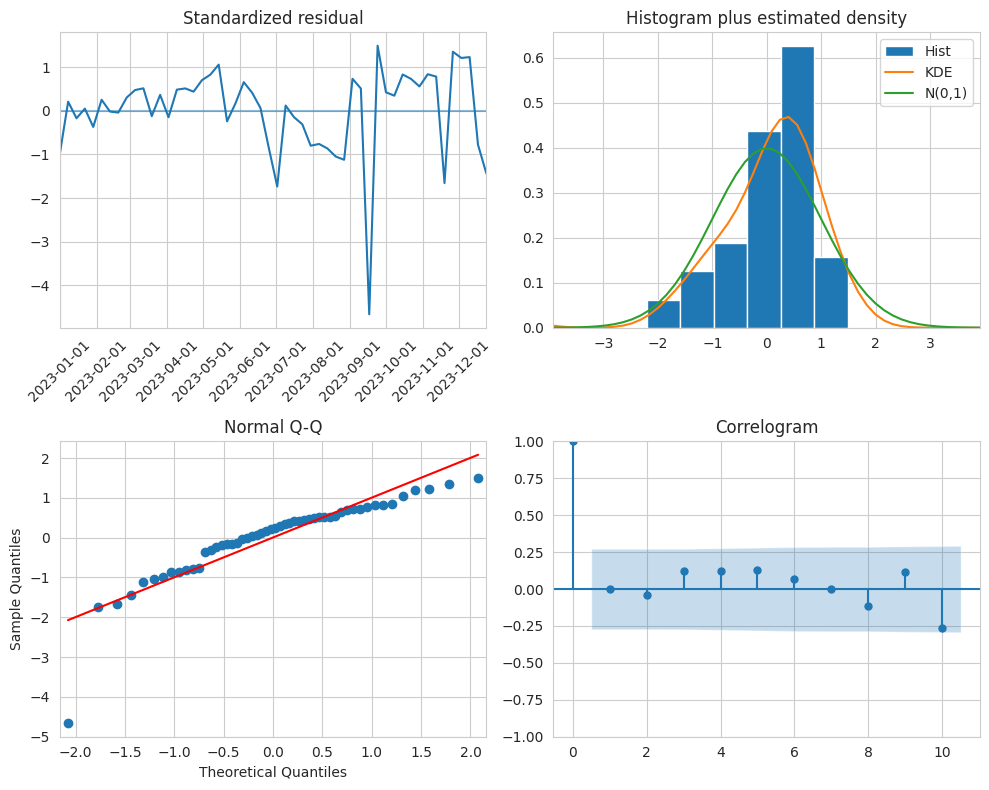

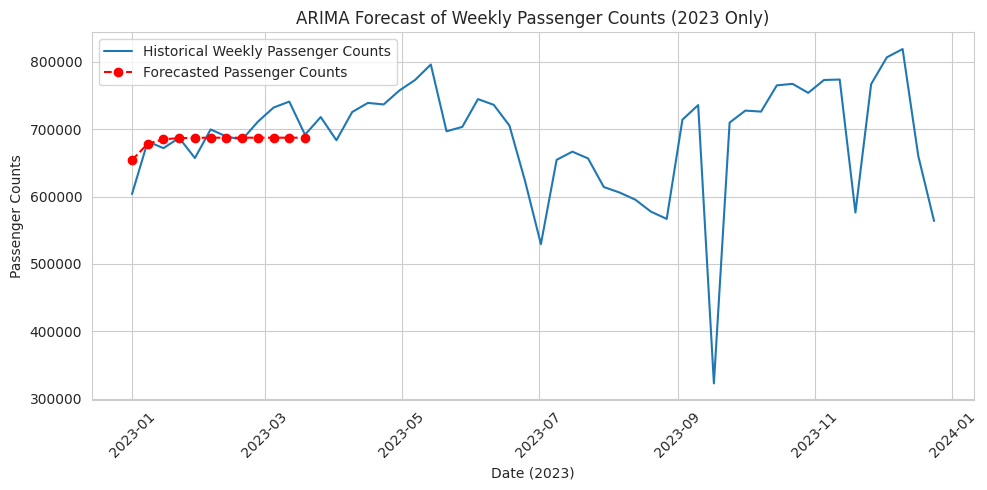

ADF Statistic: -5.227068
p-value: 0.000008


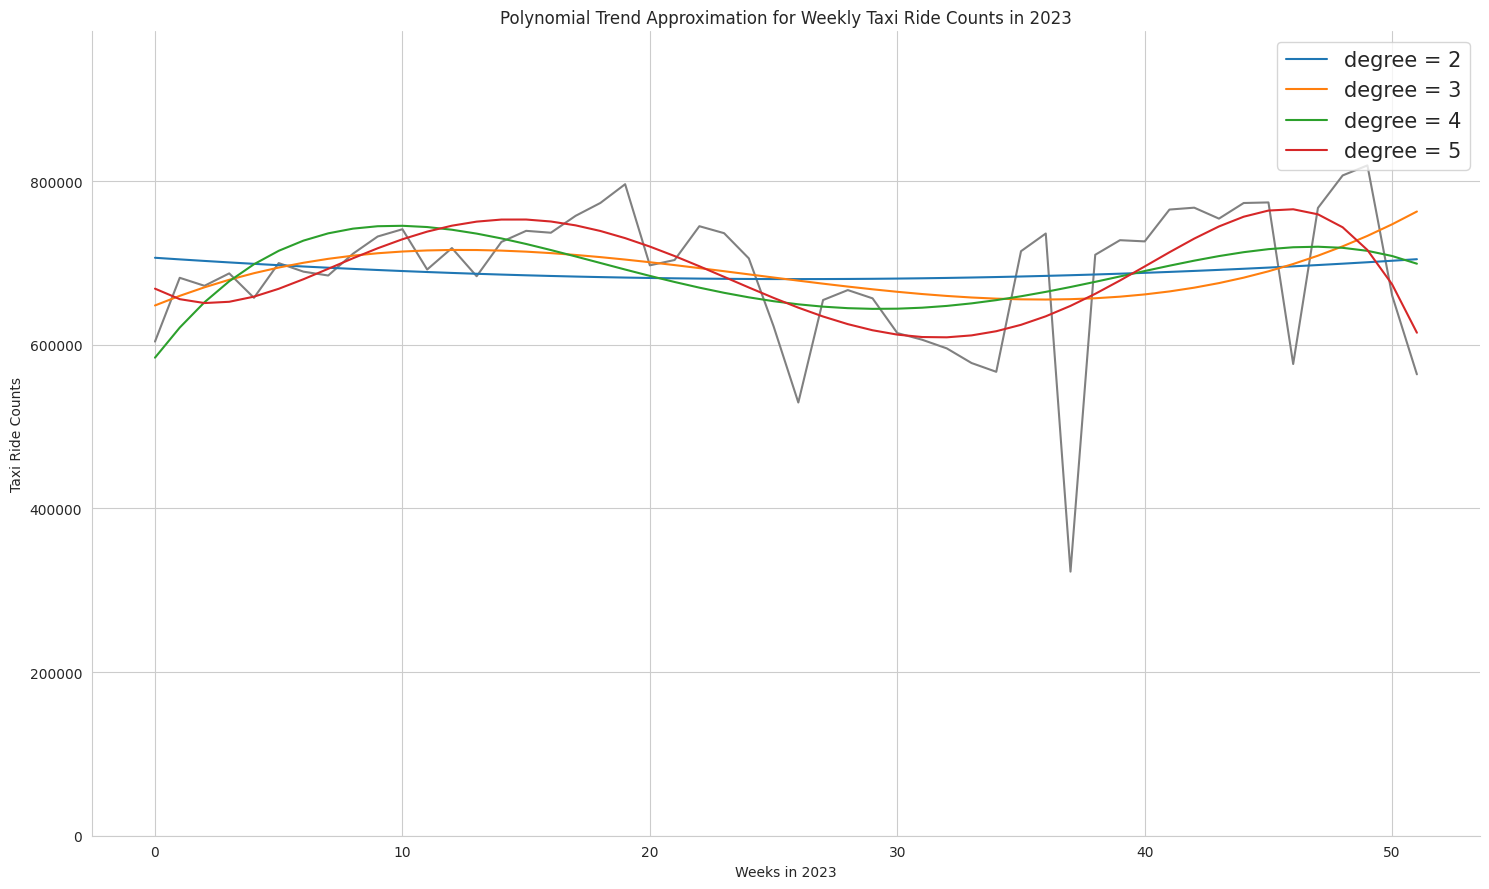

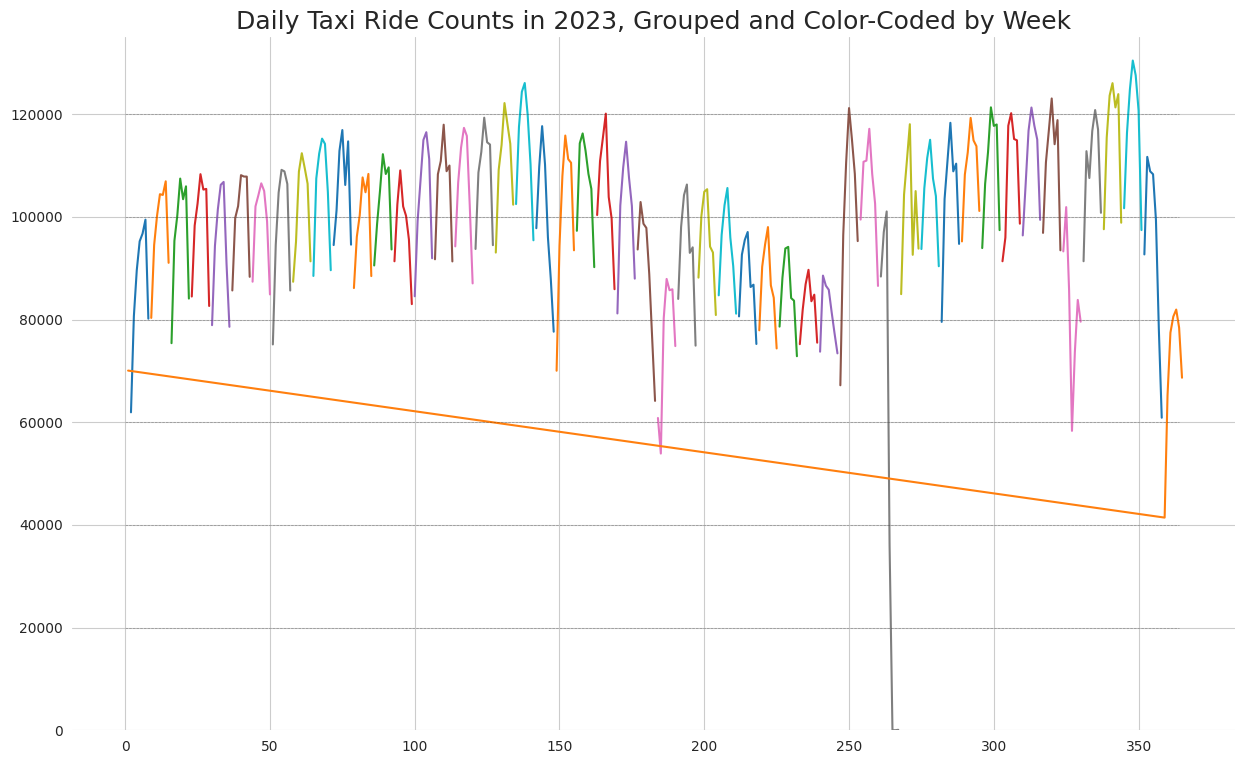

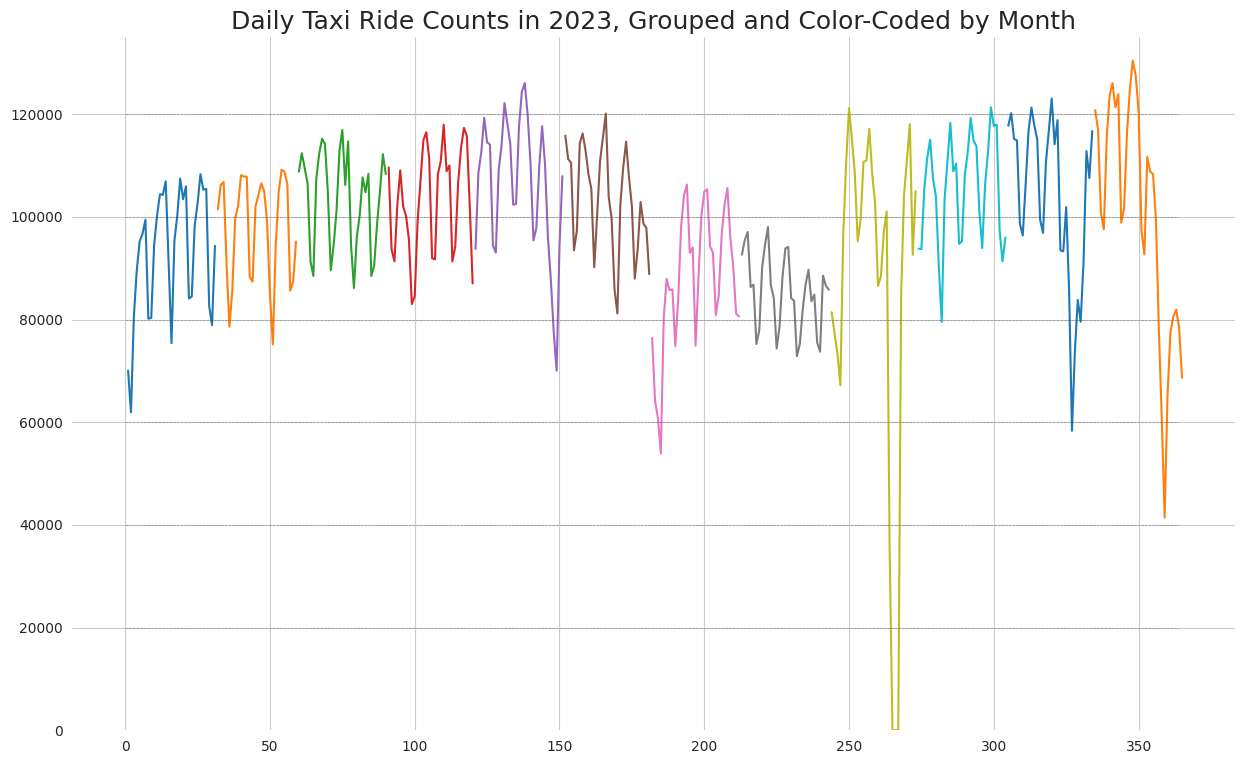

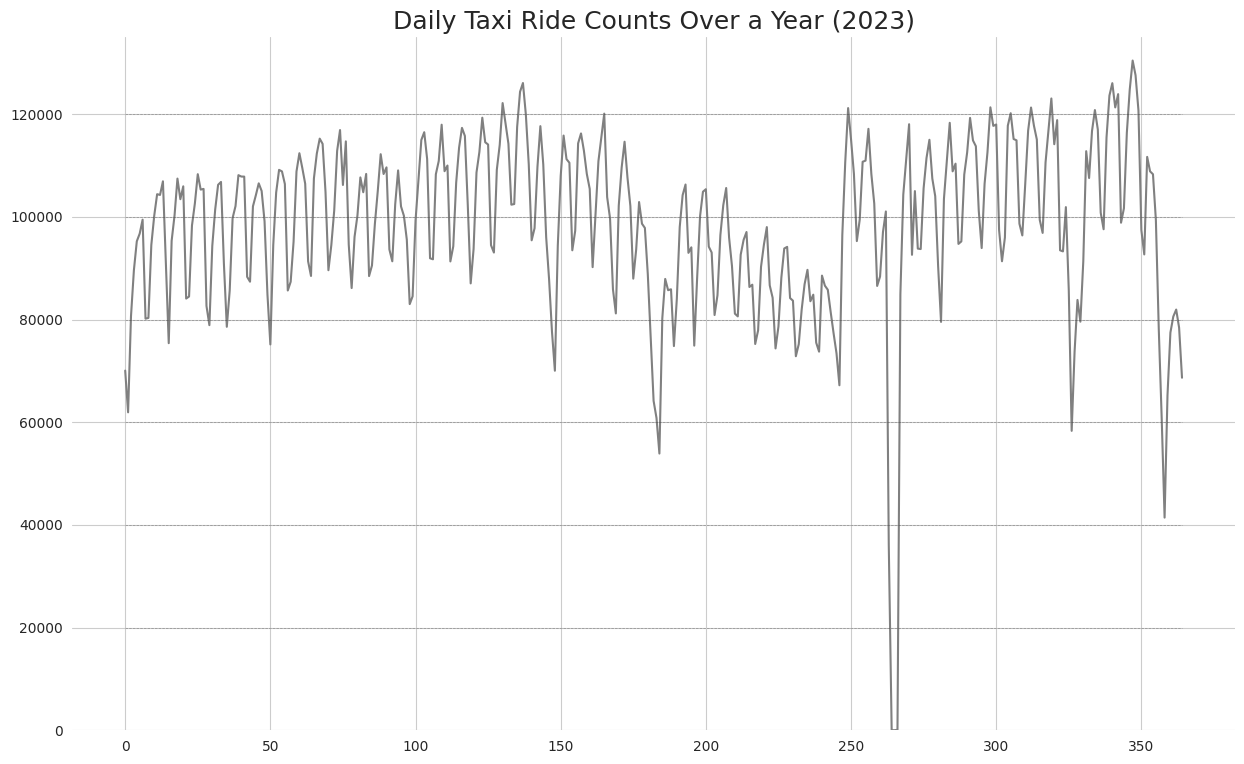

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from matplotlib.dates import DateFormatter
import pmdarima as pm
import seaborn as sns

class TimeSeriesAnalysis:
    def __init__(self, file_path):
        """Initialize the processor with a parquet file path."""
        self.file_path = file_path
        self.data = None
        self.weekly_passenger_counts = None

    def load_data(self):
        """Load and preprocess the data."""
        try:
            # Read parquet data
            self.data = pd.read_parquet(self.file_path)
            
            # Ensure all column names are lowercase
            self.data.columns = map(str.lower, self.data.columns)
            
            # Convert datetime columns to proper format
            self.data['tpep_pickup_datetime'] = pd.to_datetime(self.data['tpep_pickup_datetime'], errors='coerce')
            self.data['tpep_dropoff_datetime'] = pd.to_datetime(self.data['tpep_dropoff_datetime'], errors='coerce')
            
            # Drop rows with missing datetime values
            self.data.dropna(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime'], inplace=True)
            
            # Extract relevant time features
            self.data['year'] = self.data['tpep_pickup_datetime'].dt.year
            self.data['week'] = self.data['tpep_pickup_datetime'].dt.isocalendar().week
            self.data['month'] = self.data['tpep_pickup_datetime'].dt.month
            self.data['dayofyear'] = self.data['tpep_pickup_datetime'].dt.dayofyear
            
            # Filter for the year 2023
            self.data = self.data[self.data['year'] == 2023]
            
            # Group data by year and week to count passenger rides
            self.weekly_passenger_counts = self.data.groupby(['year', 'week']).size()

        except Exception as e:
            print(f"An error occurred during data loading: {e}")

    def adf_test(self):
        """Perform the Augmented Dickey-Fuller (ADF) test to check for stationarity."""
        if self.weekly_passenger_counts is not None:
            result = adfuller(self.weekly_passenger_counts.dropna())
            print('ADF Statistic: %f' % result[0])
            print('p-value: %f' % result[1])
        else:
            print("Weekly passenger counts are not available. Load the data first.")

    def visualize_counts(self):
        """Visualize weekly taxi ride counts."""
        if self.weekly_passenger_counts is not None:
            sns.set_style("whitegrid")
            x = np.arange(len(self.weekly_passenger_counts))
            degrees = [2, 3, 4, 5]

            fig, ax = plt.subplots(figsize=(15, 9))
            ax.plot(self.weekly_passenger_counts.values, color='gray')
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)

            for d in degrees:
                coef_t = np.polyfit(x, self.weekly_passenger_counts.values, deg=d)
                poly_t = np.poly1d(coef_t)
                trend = pd.Series(data=poly_t(x), index=self.weekly_passenger_counts.index)
                ax.plot(trend.values, label=f'degree = {d}')

            plt.legend(loc='upper right', fontsize=15)
            plt.ylim(0, max(self.weekly_passenger_counts) * 1.2)
            plt.title('Polynomial Trend Approximation for Weekly Taxi Ride Counts in 2023')
            plt.xlabel('Weeks in 2023')
            plt.ylabel('Taxi Ride Counts')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else:
            print("Weekly passenger counts are not available. Load the data first.")

    def plot_by_week(self):
        """Plot daily taxi ride counts grouped and color-coded by week."""
        fig, ax = plt.subplots(figsize=(15, 9))
        for m, group in self.data.groupby(['year', 'week']):
            data = group['dayofyear'].value_counts(sort=False).sort_index()
            ax.plot(data)
        
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

        plt.ylim(0, 135000)
        plt.yticks(fontsize=10)
        plt.tick_params(axis="both", which="both", bottom=False, top=False,
                        labelbottom=True, left=False, right=False, labelleft=True)

        for j in range(0, 130000, 20000):
            plt.plot(range(0, 365), [j] * len(range(0, 365)), "--", lw=0.5, color="black", alpha=0.3)

        plt.title('Daily Taxi Ride Counts in 2023, Grouped and Color-Coded by Week', fontsize=18)
        plt.show()

    def plot_by_month(self):
        """Plot daily taxi ride counts grouped and color-coded by month."""
        fig, ax = plt.subplots(figsize=(15, 9))
        for m, group in self.data.groupby('month'):
            data = group['dayofyear'].value_counts(sort=False).sort_index()
            ax.plot(data)
        
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

        plt.ylim(0, 135000)
        plt.yticks(fontsize=10)
        plt.tick_params(axis="both", which="both", bottom=False, top=False,
                        labelbottom=True, left=False, right=False, labelleft=True)

        for j in range(0, 130000, 20000):
            plt.plot(range(0, 365), [j] * len(range(0, 365)), "--", lw=0.5, color="black", alpha=0.3)

        plt.title('Daily Taxi Ride Counts in 2023, Grouped and Color-Coded by Month', fontsize=18)
        plt.show()

    def plot_yearly_counts(self):
        """Plot daily taxi ride counts for 2023 over the entire year."""
        counts = self.data['dayofyear'].value_counts(sort=False).sort_index()
        
        fig, ax = plt.subplots(figsize=(15, 9))
        ax.plot(counts.values, color='gray')
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

        plt.ylim(0, 135000)
        plt.yticks(fontsize=10)
        plt.tick_params(axis="both", which="both", bottom=False, top=False,
                        labelbottom=True, left=False, right=False, labelleft=True)

        for j in range(0, 130000, 20000):
            plt.plot(range(0, 365), [j] * len(range(0, 365)), "--", lw=0.5, color="black", alpha=0.3)

        plt.title('Daily Taxi Ride Counts Over a Year (2023)', fontsize=18)
        plt.show()


class ARIMAForecaster:
    def __init__(self, data_series):
        """Initialize the ARIMA forecaster with a series to analyze."""
        self.data_series = data_series
        self.model = None
        self.forecasts = None

    def preprocess_data(self):
        """Preprocess the data for ARIMA modeling."""
        # Make sure the data series is indexed by date
        if not isinstance(self.data_series.index, pd.DatetimeIndex):
            self.data_series.index = pd.date_range(start='2023-01-01', periods=len(self.data_series), freq='W')

    def auto_fit(self, seasonal=False, m=1):
        """Automatically fit an ARIMA model with modified seasonal settings."""
        self.preprocess_data()
        try:
            self.model = pm.auto_arima(self.data_series, seasonal=seasonal, m=m, suppress_warnings=True)
            print(self.model.summary())
        except ValueError as e:
            print(f"An error occurred while fitting the model: {e}")
            print("Adjust the seasonal settings or increase the sample size.")

    def plot_diagnostics(self):
        """Plot the diagnostic figures for the ARIMA model."""
        if self.model is None:
            raise ValueError("Model is not fitted yet.")
        fig = self.model.plot_diagnostics(figsize=(10, 8))

        axes = fig.get_axes()
        standard_resid_ax = axes[0]
        standard_resid_ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
        standard_resid_ax.tick_params(axis='x', rotation=45)
        fig.tight_layout()
        plt.show()

    def forecast(self, periods=12):
        """Generate future forecasts and visualize them."""
        if self.model is None:
            raise ValueError("Model is not fitted yet.")
        self.forecasts, _ = self.model.predict(n_periods=periods, return_conf_int=True)

        forecast_dates_2023 = pd.date_range(start='2023-01-01', periods=periods, freq='W')
        historical_2023 = self.data_series[self.data_series.index >= '2023-01-01']

        plt.figure(figsize=(10, 5))
        plt.plot(historical_2023.index, historical_2023, label='Historical Weekly Passenger Counts')
        plt.plot(forecast_dates_2023, self.forecasts, label='Forecasted Passenger Counts', linestyle='--', marker='o', color='red')
        plt.title('ARIMA Forecast of Weekly Passenger Counts (2023 Only)')
        plt.xlabel('Date (2023)')
        plt.ylabel('Passenger Counts')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Executing the full process
def main():
    # Initialize the TimeSeriesAnalysis and load data
    tsa = TimeSeriesAnalysis(file_path="/app/full_df.parquet")
    tsa.load_data()

    # Initialize the forecaster and fit an ARIMA model
    forecaster = ARIMAForecaster(tsa.weekly_passenger_counts)
    forecaster.auto_fit()
    forecaster.plot_diagnostics()
    forecaster.forecast()

    # After fitting the ARIMA model, perform the ADF test and visualize counts
    tsa.adf_test()
    tsa.visualize_counts()
    tsa.plot_by_week()
    tsa.plot_by_month()
    tsa.plot_yearly_counts()

if __name__ == '__main__':
    main()
